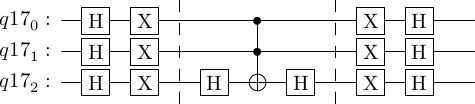

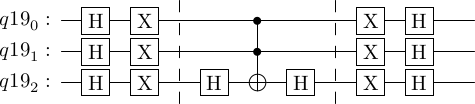

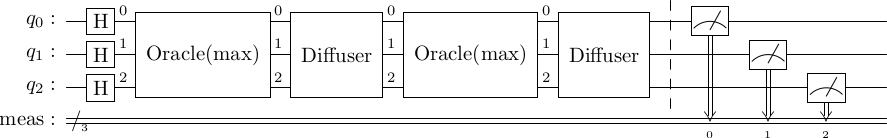

C:\Users\shyam\AppData\Local\Temp\ipykernel_29756\3916489703.py:73: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [7]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.quantum_info import Operator
import numpy as np

class GroverMax:
    def __init__(self, *numbers):
        """
        Initialize with a list of numbers to find the maximum.
        """
        self.numbers = numbers
        self.max_number = max(numbers)
        self.nqubits = max(max(abs(num) for num in numbers).bit_length(), 3)
        self.nstates = 2 ** self.nqubits

    def create_oracle(self):
        """
        Create an oracle that marks the maximum number.
        """
        qr = QuantumRegister(self.nqubits)
        qc = QuantumCircuit(qr, name='Oracle(max)')
        
        # Create the gate matrix for the oracle
        gate_matrix = np.eye(2 ** self.nqubits, dtype=int)
        i = abs(self.max_number)
        gate_matrix[i][i] = -1
        
        max_operator = Operator(gate_matrix)
        qc.unitary(max_operator, range(self.nqubits))
        
        #display(qc.draw(output='latex'))
        return qc.to_instruction()

    def create_diffuser(self):
        """
        Create a Grover diffuser for the number of qubits.
        """
        qr = QuantumRegister(self.nqubits)
        qc = QuantumCircuit(qr, name='Diffuser')
        
        qc.h(range(self.nqubits))
        qc.x(range(self.nqubits))
        qc.barrier(range(self.nqubits))
        qc.h(self.nqubits - 1)
        qc.mcx(list(range(self.nqubits - 1)), self.nqubits - 1)
        qc.h(self.nqubits - 1)
        qc.barrier(range(self.nqubits))
        qc.x(range(self.nqubits))
        qc.h(range(self.nqubits))
        
        display(qc.draw(output='latex'))
        return qc.to_instruction()

    def find_max(self):
        """
        Use Grover's algorithm to find the maximum number.
        """
        qc = QuantumCircuit(self.nqubits)
        qc.h(range(self.nqubits))  # Apply Hadamard to create superposition
        
        # Grover iterations
        niterations = int(np.floor(np.pi / 4 * np.sqrt(self.nstates)))
        for _ in range(niterations):
            qc.append(self.create_oracle(), range(self.nqubits))
            qc.append(self.create_diffuser(), range(self.nqubits))
        
        qc.measure_all()
        
        display(qc.draw(output='latex'))
        #plt.show()

        # Simulate the circuit
        sampler = Sampler()
        result = sampler.run(qc).result()
        counts = result.quasi_dists[0]
        
        # Find the key with the highest value without using max
        max_candidate = None
        max_value = float('-inf')
        for key, value in counts.items():
            if value > max_value:
                max_value = value
                max_candidate = key
        
        # Return the max number if the result matches, else None
        return self.max_number if abs(self.max_number) == max_candidate else None

grover_search = GroverMax(0, -1, -2, -1)
score = grover_search.find_max()